In [12]:
#importing libraries
import os
import re
import nltk

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Overview of data

In [ ]:
#function for reading csv tables into dataframes
def read_csv_files(path):
    file_list=os.listdir(path)
    dataframes=[]
    for file_name in file_list:
        file_path=os.path.join(path, file_name)

        if file_name.endswith('.csv'):
            df=pd.read_csv(file_path)
            df.drop(columns=["url", "content"],inplace=True)
            dataframes.append(df)
        elif file_name.endswith('.json'):
            df = pd.read_json(file_path, lines=True)  # Read JSONL files
            df.drop(columns=['authors', 'link', 'date'], inplace=True, errors='ignore')
            df.rename(columns = {'headline':'headlines', 'short_description':'description'}, inplace = True)
            df.loc[:,['headlines','description','category']]
            dataframes.append(df)

    #shuffling the columns for the randomness and resetting index of df
    combined_df=shuffle(pd.concat(dataframes, ignore_index=True))

    return combined_df

In [ ]:
path=r'/topic-classification'
df=read_csv_files(path)

df.head()

headlines  \
117058                               Kisses For My Mother   
79803   Teen's Taco Bell-Themed Senior Photos Will Ins...   
50152   How Trump’s Budget Would Hurt Kids – And U.S. ...   
16387              3 Dead, 13 Injured In Toronto Shooting   
32851   The Ultimate Livingston, Montana, Road Trip Pl...   

                                              description       category  
117058  The place where I had felt most safe and loved...          FIFTY  
79803                       Taco Bell + Nathaniel = Love.      GOOD NEWS  
50152   Congress should make it clear that relegating ...  THE WORLDPOST  
16387   The fatalities include an 18-year-old and 10-y...     WORLD NEWS  
32851   Big Sky Country likes a blend of rock and pop,...  ENTERTAINMENT

In [ ]:
print(df.shape)

(219527, 3)


In [ ]:
# information about metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219527 entries, 117058 to 167583
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   headlines    219527 non-null  object
 1   description  219527 non-null  object
 2   category     219527 non-null  object
dtypes: object(3)
memory usage: 6.7+ MB


In [ ]:
# Print distinct values of the 'cat' feature
print("Distinct categories:", df['category'].unique())

df['category'] = df['category'].str.upper()
df['category'].replace('TECH', 'TECHNOLOGY', inplace=True)
print("Distinct categories:", df['category'].unique())


Distinct categories: ['FIFTY' 'GOOD NEWS' 'THE WORLDPOST' 'WORLD NEWS' 'ENTERTAINMENT' 'SPORTS'
 'TRAVEL' 'BUSINESS' 'SCIENCE' 'WOMEN' 'WELLNESS' 'POLITICS' 'sports'
 'QUEER VOICES' 'HEALTHY LIVING' 'ARTS' 'PARENTS' 'WEDDINGS' 'PARENTING'
 'STYLE & BEAUTY' 'WEIRD NEWS' 'COLLEGE' 'ARTS & CULTURE' 'TECH'
 'ENVIRONMENT' 'DIVORCE' 'technology' 'WORLDPOST' 'RELIGION' 'CRIME'
 'FOOD & DRINK' 'MONEY' 'EDUCATION' 'COMEDY' 'education' 'MEDIA' 'TASTE'
 'IMPACT' 'entertainment' 'business' 'BLACK VOICES' 'GREEN'
 'HOME & LIVING' 'LATINO VOICES' 'STYLE' 'U.S. NEWS' 'CULTURE & ARTS']
Distinct categories: ['FIFTY' 'GOOD NEWS' 'THE WORLDPOST' 'WORLD NEWS' 'ENTERTAINMENT' 'SPORTS'
 'TRAVEL' 'BUSINESS' 'SCIENCE' 'WOMEN' 'WELLNESS' 'POLITICS'
 'QUEER VOICES' 'HEALTHY LIVING' 'ARTS' 'PARENTS' 'WEDDINGS' 'PARENTING'
 'STYLE & BEAUTY' 'WEIRD NEWS' 'COLLEGE' 'ARTS & CULTURE' 'TECHNOLOGY'
 'ENVIRONMENT' 'DIVORCE' 'WORLDPOST' 'RELIGION' 'CRIME' 'FOOD & DRINK'
 'MONEY' 'EDUCATION' 'COMEDY' 'MEDIA' 'TASTE' 'IMPA

In [ ]:
# Calculate the number of missing/distinct values and duplicate rows for each feature
print("Number of missing values\n", df.isnull().sum())
print("\nNumber of distinct values\n", df.nunique())
print("\nNumber of duplicates\n", df.duplicated().sum())

Number of missing values
 headlines      0
description    0
category       0
dtype: int64

Number of distinct values
 headlines      217983
description    197000
category           42
dtype: int64

Number of duplicates
 482


In [ ]:
# Remove duplicates
df.drop_duplicates(subset=['headlines', 'description', 'category'], keep='first', inplace=True)
print("\nNumber of duplicates\n", df.duplicated().sum())


Number of duplicates
 0


In [ ]:
df.describe()

headlines description  category
count           219045      219045    219045
unique          217983      197000        42
top     Sunday Roundup              POLITICS
freq                90       19619     35585

## EDA

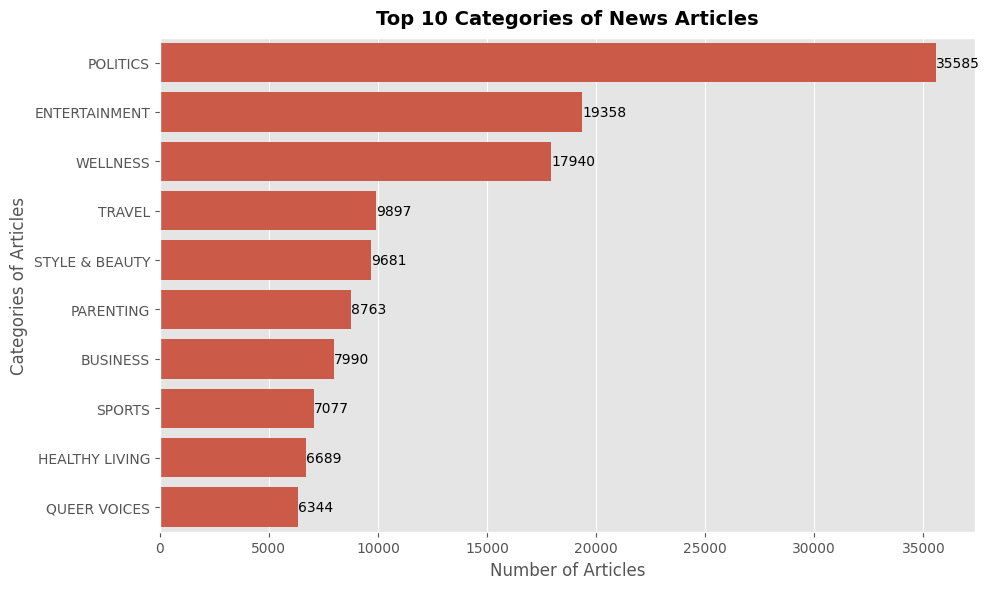

In [ ]:
# Plotting the top 0 categories
cat_df = pd.DataFrame(df['category'].value_counts()).reset_index()

plt.figure(figsize=(10,6))
ax=sns.barplot(cat_df[:10], x="count", y="category", estimator="sum")
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('Top 10 Categories of News Articles')
plt.xlabel('Number of Articles')
plt.ylabel('Categories of Articles')
plt.savefig('/topic-classification/outputs/top_10_categories_of_articles', bbox_inches='tight')
plt.show()


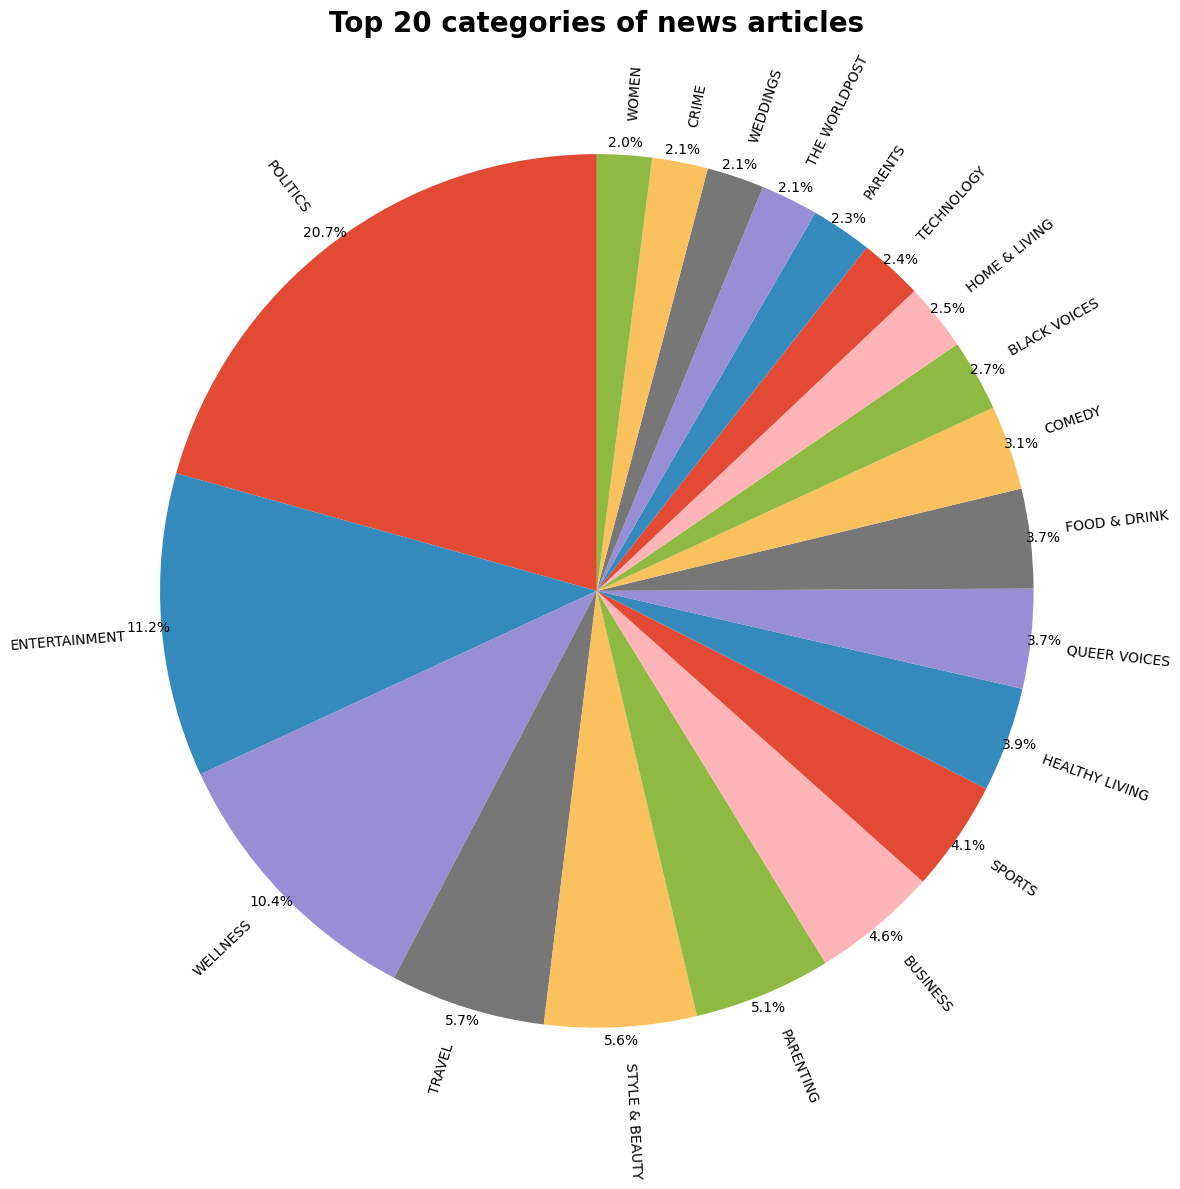

In [ ]:
# Plotting the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['count'][:20],
            labels=cat_df['category'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Top 20 categories of news articles", size=20, weight='bold')
plt.savefig('/topic-classification/outputs/top_20_categories_of_articles', bbox_inches='tight')
plt.show()

(-0.5, 1599.5, 599.5, -0.5)

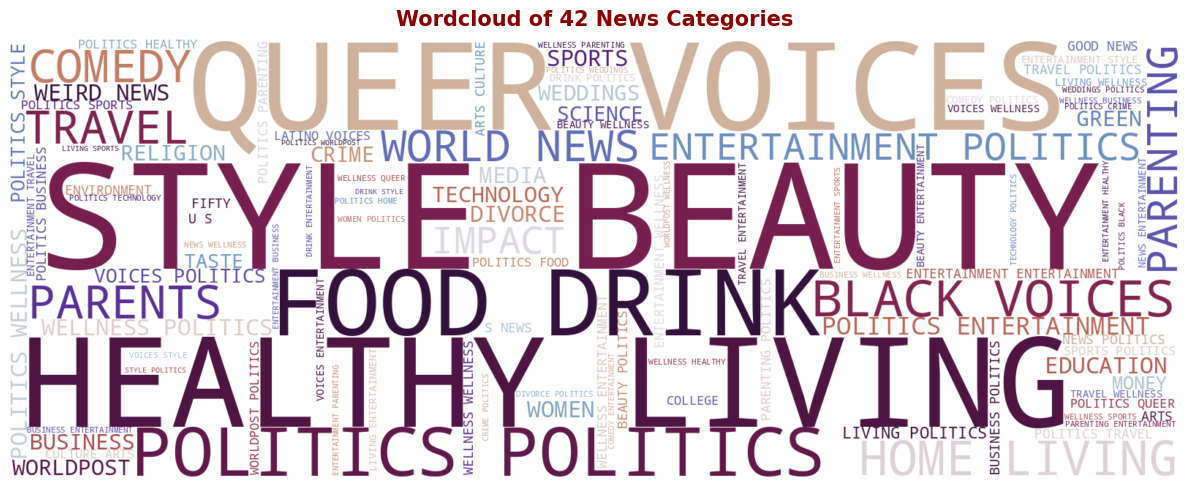

In [ ]:
# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='white',
               contour_color='white',
               colormap='twilight_r',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(df.category))

plt.title("Wordcloud of 42 News Categories", size=15, weight='bold', color='darkred')
plt.imshow(wc, interpolation= "bilinear")
plt.savefig('/topic-classification/outputs/wordcloud', bbox_inches='tight')
plt.axis('off')


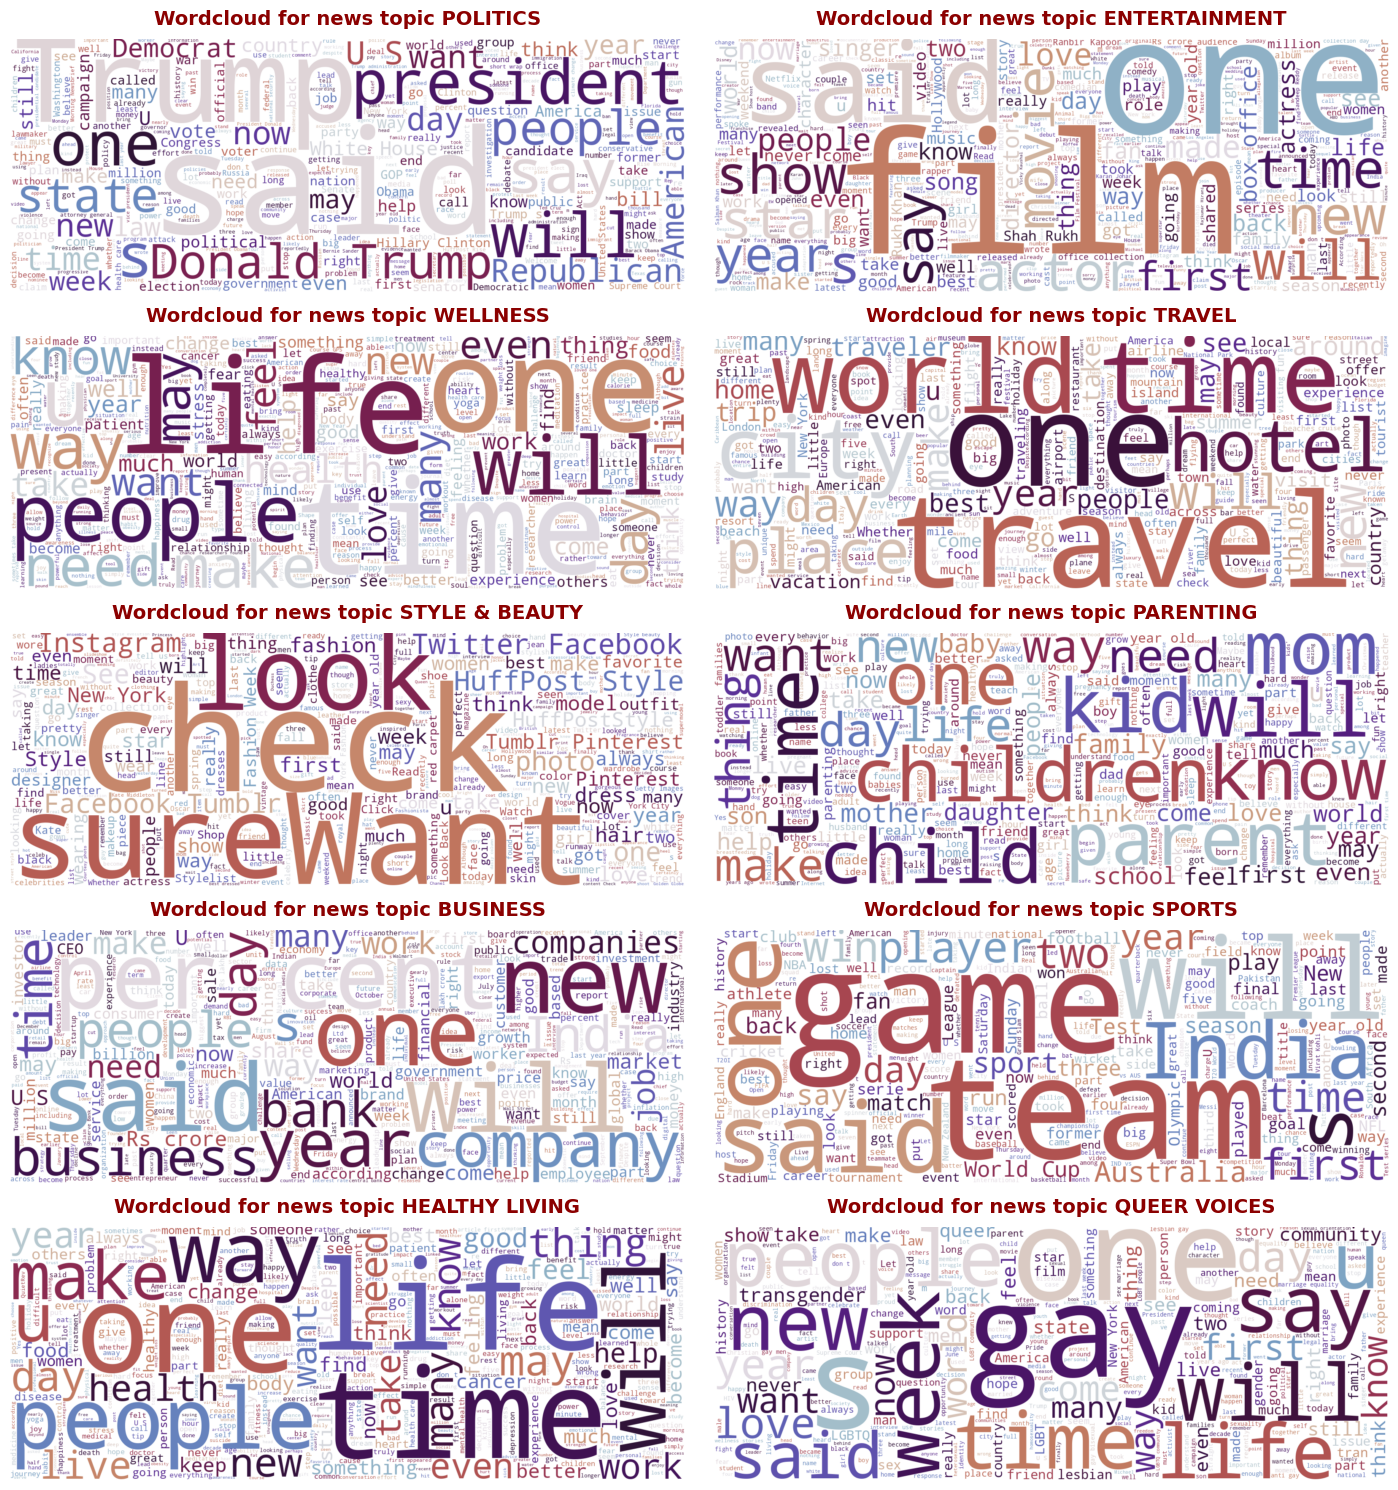

In [ ]:
# list of top 10  categories in out dataset
categories = cat_df['category'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    catw_df = df[df['category'] == i]
    catw_array = catw_df['description'].values  # array of news articles text in each category
    articles_list.append(catw_array)

# create a wordcloud instance
wc1 = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='white',
               contour_color='white',
               colormap='twilight_r',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}", weight='bold', color='darkred')
    plt.axis('off')

plt.savefig(f'/topic-classification/outputs/wordclouds', bbox_inches='tight')

## Data Preprocessing

In [ ]:
content_df=df.copy()
content_df.drop(columns=["headlines"],inplace=True)
content_df.head()

description       category
117058  The place where I had felt most safe and loved...          FIFTY
79803                       Taco Bell + Nathaniel = Love.      GOOD NEWS
50152   Congress should make it clear that relegating ...  THE WORLDPOST
16387   The fatalities include an 18-year-old and 10-y...     WORLD NEWS
32851   Big Sky Country likes a blend of rock and pop,...  ENTERTAINMENT

In [ ]:
# start with removing some data from politics dataframe ndf
politics_list = list(content_df[content_df['category'] == 'POLITICS'].index)
list_16 = politics_list[:16000] # list of 16000 row labels of POLITICS category

content_df.drop(list_16, axis=0, inplace=True)

In [ ]:
# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()

    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]

    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

In [ ]:
# Example of pre-processing using above function
print("Text sentence before pre-processing:\n",content_df['description'][0])
print("---"*35)
print("Text sentence after pre-processing:\n",datacleaning(content_df['description'][0]))

Text sentence before pre-processing:
 That e-reader screen isn't magic - it's E Ink! We break down the science behind these paper-like displays.
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 ereader screen isnt magic e ink break science behind paperlike display


In [ ]:
# Applying datacleaning function to column 'length_of_news'
content_df['description'] = content_df['description'].apply(datacleaning)

In [ ]:
# Length of total characters before and after cleaning text data
old_length = df['description'].apply(len).sum()
new_length = content_df['description'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 25468656
New chracters length of text data: 15312613


In [ ]:
# Length of total words before and after cleaning text data
old_text = df['description'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = content_df['description'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 4376711
New word length of text data: 2249924


## Tokenization and Vectorization

In [ ]:
# tokenization and vectorization workflow
# word level one-hot encoding for sample data

samples = list(content_df["description"][:5].values)  # samples of first 5 documents of out dataset

token_index = {}  # builds an index of tokens in the data
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # assigning unique index to each unique words

max_length = 15

results = np.zeros(shape=(len(samples),   # results will be stored in this array
                          max_length,
                          max(token_index.values()) +1))

print("Shape of stored results array:", results.shape)
print("Token index of unique words: \n", token_index)

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape of stored results array: (5, 15, 57)
Token index of unique words: 
 {'place': 1, 'felt': 2, 'safe': 3, 'love': 4, 'infant': 5, 'mother': 6, 'arm': 7, 'nose': 8, 'mouth': 9, 'press': 10, 'skin': 11, 'heart': 12, 'shoulder': 13, 'call': 14, 'back': 15, 'say': 16, 'goodbye': 17, 'good': 18, 'night': 19, 'sweet': 20, 'beautiful': 21, 'thank': 22, 'well': 23, 'taco': 24, 'bell': 25, 'nathaniel': 26, 'congress': 27, 'make': 28, 'clear': 29, 'relegate': 30, 'millions': 31, 'children': 32, 'exploitation': 33, 'lifelong': 34, 'poverty': 35, 'consistent': 36, 'either': 37, 'american': 38, 'priorities': 39, 'value': 40, 'fatalities': 41, 'include': 42, 'yearold': 43, 'motive': 44, 'attack': 45, 'yet': 46, 'determine': 47, 'big': 48, 'sky': 49, 'country': 50, 'like': 51, 'blend': 52, 'rock': 53, 'pop': 54, 'spotify': 55, 'find': 56}


In [ ]:
# one hot encoding using keras tokenizer and pad sequencing
X = content_df["description"]
encoder = LabelEncoder()
y = encoder.fit_transform(content_df['category'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>')
tokenizer.fit_on_texts(X_train) # build the word index

# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=100) # pads the integer lists to 2D integer tensor

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=100)

word_index = tokenizer.word_index
max_words = 200000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1
maxlen = 100 # max length of sequence
num_classes = len(encoder.classes_)

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
print("Length of word index:", total_words)

shape of input data:  (203045,)
shape of target variable:  (203045,)
Length of word index: 76299


In [ ]:
print(train_seq[1])
print(train_padseq[1])

[16, 569, 169, 29, 454, 1676, 37489, 37490, 1061, 59, 297, 2653, 967, 1170, 237, 4, 983, 4104, 280, 13347, 20396, 37491, 188]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0    16   569   169    29   454  1676 37489
 37490  1061    59   297  2653   967  1170   237     4   983  4104   280
 13347 20396 37491   188]


In [ ]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)

    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))

    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    plt.savefig(f'/topic-classification/outputs/training_val_acc', bbox_inches='tight')

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    plt.savefig(f'/topic-classification/outputs/training_val_loss', bbox_inches='tight')

    plt.show()

## Baseline Model Building using Embedding Layer and RNN

In [ ]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 70)           5331410   
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          17280     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 128)          24704     
 onal)                                                           
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 42)                1

In [ ]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min')
checkpointer = ModelCheckpoint(filepath='best_model.h5',monitor='val_loss', verbose=1, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train,
                   batch_size=128,
                   epochs=15,
                   validation_split=0.2,
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
1016/1016 [==============================] - ETA: 0s - loss: 3.2104 - accuracy: 0.1653
Epoch 1: val_loss improved from inf to 3.00064, saving model to best_model.h5
1016/1016 [==============================] - 612s 596ms/step - loss: 3.2104 - accuracy: 0.1653 - val_loss: 3.0006 - val_accuracy: 0.2113
Epoch 2/15
1016/1016 [==============================] - ETA: 0s - loss: 2.8434 - accuracy: 0.2592
Epoch 2: val_loss improved from 3.00064 to 2.71197, saving model to best_model.h5
1016/1016 [==============================] - 582s 573ms/step - loss: 2.8434 - accuracy: 0.2592 - val_loss: 2.7120 - val_accuracy: 0.2945
Epoch 3/15
1016/1016 [==============================] - ETA: 0s - loss: 2.6328 - accuracy: 0.3160
Epoch 3: val_loss improved from 2.71197 to 2.63155, saving model to best_model.h5
1016/1016 [==============================] - 582s 573ms/step - loss: 2.6328 - accuracy: 0.3160 - val_loss: 2.6316 - val_accuracy: 0.3244
Epoch 4/15
1016/1016 [==============================]

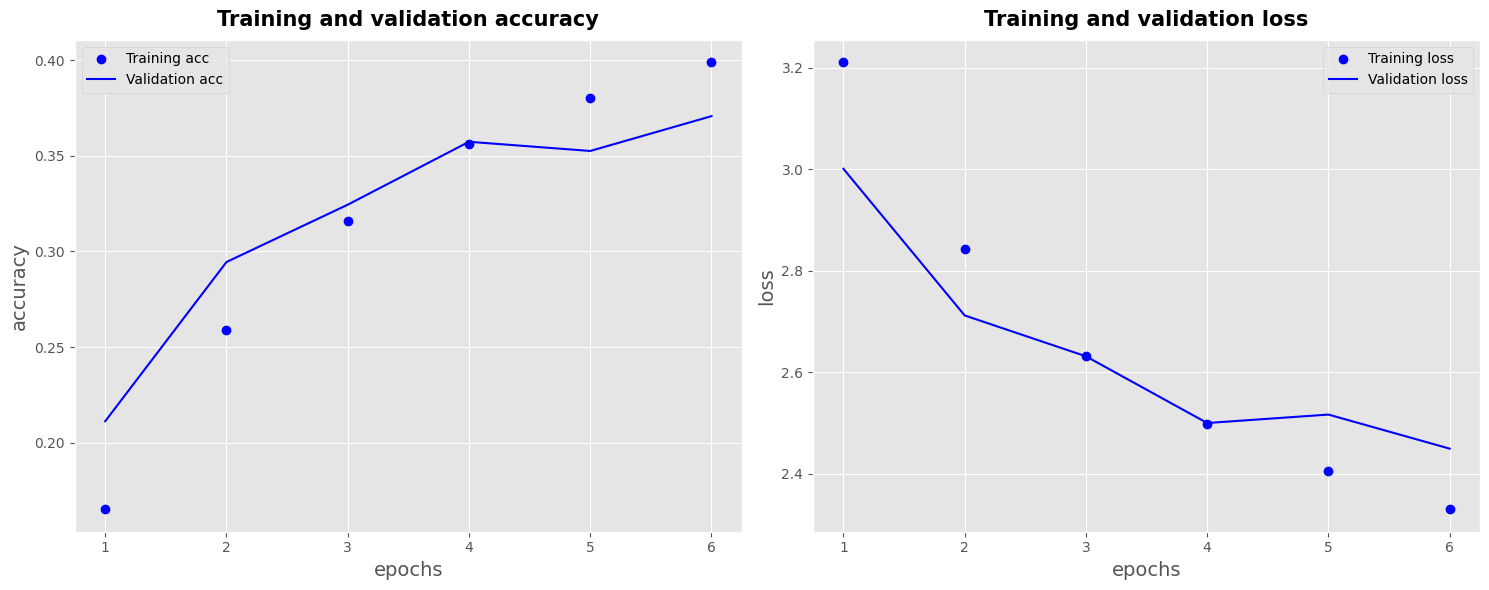

In [ ]:
plot_loss_accuracy(history)

## Enhanced Model

In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(42, activation='softmax'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          7629900   
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 128)          24704     
 onal)                                                           
                                                                 
 conv1d (Conv1D)             (None, 98, 72)            27720     
                                                        

In [15]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min')

checkpointer = ModelCheckpoint(filepath='best_model.h5',monitor='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, y_train,
                     batch_size=128,
                     epochs=15,
                     validation_split=0.2,
                     shuffle=True)

# evalute the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

Epoch 1/20
1016/1016 [==============================] - 1719s 2s/step - loss: 3.4193 - accuracy: 0.1961 - val_loss: 3.8888 - val_accuracy: 0.3028
Epoch 2/20
1016/1016 [==============================] - 1656s 2s/step - loss: 3.3720 - accuracy: 0.2183 - val_loss: 3.5476 - val_accuracy: 0.3347
Epoch 3/20
1016/1016 [==============================] - 1648s 2s/step - loss: 3.2429 - accuracy: 0.3288 - val_loss: 3.4671 - val_accuracy: 0.3483
Epoch 4/20
1016/1016 [==============================] - 1647s 2s/step - loss: 3.2103 - accuracy: 0.3308 - val_loss: 3.4280 - val_accuracy: 0.3576
Epoch 5/20
1016/1016 [==============================] - 1607s 2s/step - loss: 3.0207 - accuracy: 0.3614 - val_loss: 3.1363 - val_accuracy: 0.3607
Epoch 6/20
1016/1016 [==============================] - 1645s 2s/step - loss: 2.9391 - accuracy: 0.4098 - val_loss: 3.0227 - val_accuracy: 0.4092
Epoch 7/20
1016/1016 [==============================] - 1644s 2s/step - loss: 2.8023 - accuracy: 0.4281 - val_loss: 2.9894 -

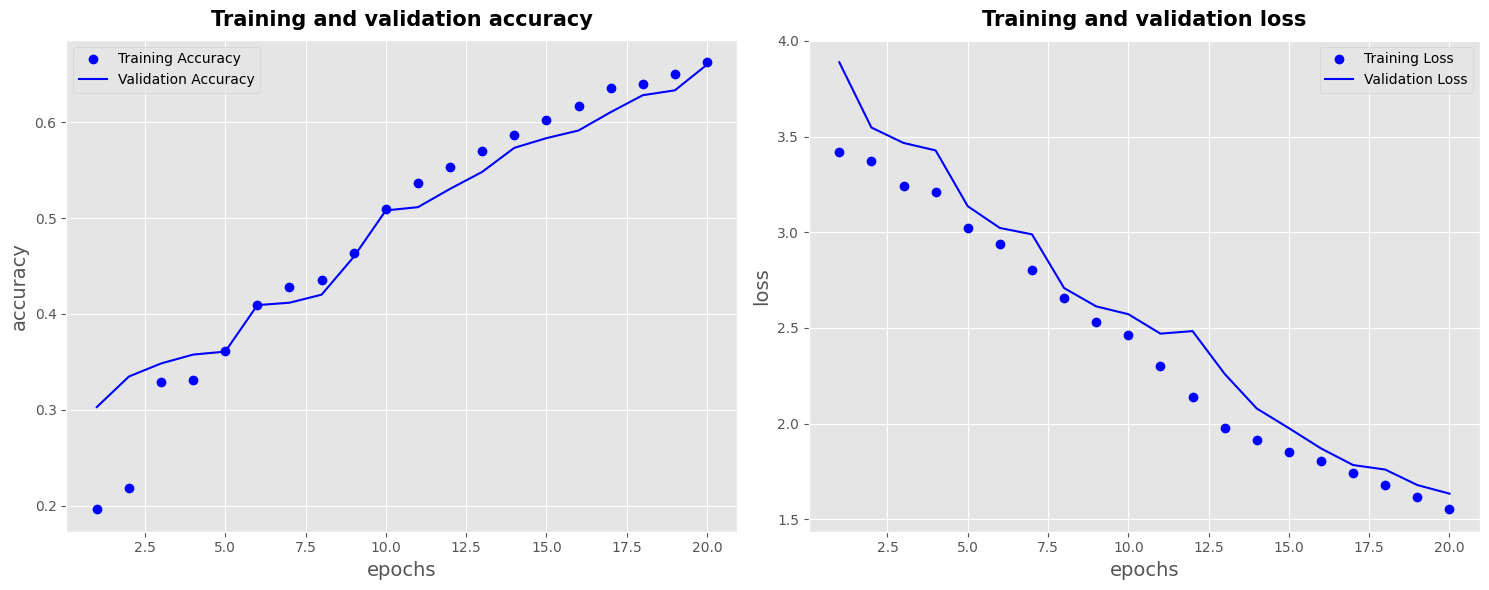

In [16]:
plot_loss_accuracy(history2)